# Exercise 02: AlphaFold Structure Prediction and Rational Protein Design

## Learning Objectives

In this exercise, you will:
- Use AlphaFold to predict protein structures
- **Design sequences** that fold into specific secondary structures
- **Interpret confidence metrics** (pLDDT, PAE) critically
- **Hypothesize and test** structure-disrupting mutations
- **Compare** predicted vs experimental structures
- **Justify** your design choices using structural biology principles

## About AI and This Exercise

**What AI CAN help with:**
- Understanding AlphaFold parameters
- Syntax for running predictions
- General protein folding principles

**What YOU must demonstrate:**
- **Design strategy** - WHY you chose specific amino acids
- **Hypothesis formulation** - predictions before running AlphaFold
- **Critical evaluation** - interpreting what worked and what didn't
- **Biological reasoning** - connecting sequence to structure to function

**Important:** Simply generating sequences with AI and testing them randomly shows no understanding. You must explain your reasoning.

---

Based on [Sergey Ovchinnikov's af_backprop](https://github.com/sokrypton/af_backprop)

# Alphafold

[AlphaFold](https://deepmind.google/technologies/alphafold/), an AI system developed by DeepMind, has solved the complex protein-folding problem, allowing for almost instant and highly accurate predictions of protein structures, which are crucial for understanding cellular functions and advancing medical research. Recognized by the [Critical Assessment of protein Structure Prediction community](https://www.predictioncenter.org/), AlphaFold has [significantly](https://www.predictioncenter.org/casp14/zscores_final.cgi) expanded the availability of protein structure data through the freely accessible AlphaFold Protein Structure Database.

In [2]:
# @title Setup Cell 🏗️
# @markdown This cell sets up the complete AlphaFold environment including downloading parameters, installing dependencies, and defining prediction functions.
# @markdown **Run this cell first before making any predictions.**

# ============================================
# JAX VERSION FIX FOR GOOGLE COLAB
# ============================================
# Check if running in Colab and install compatible JAX version
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    print("🔧 Installing JAX compatible with AlphaFold...")
    import subprocess

    result = subprocess.run(
        [
            sys.executable,
            "-m",
            "pip",
            "install",
            "--upgrade",
            "jax[cuda12]==0.5.3",
            "jaxlib==0.5.3",
            "-q",
        ],
        capture_output=True,
    )
    if result.returncode == 0:
        print("✅ JAX 0.5.3 installed successfully")
        print(
            "⚠️  IMPORTANT: Please restart the runtime now (Runtime → Restart runtime)"
        )
        print("    Then run this cell again to continue with the setup.")
    else:
        print("❌ Failed to install JAX. Error:", result.stderr.decode())
else:
    print("ℹ️  Not in Colab, skipping JAX version check")

print("\n" + "=" * 60)
print("Setting up AlphaFold environment...")
print("=" * 60 + "\n")

import logging
import os
import re
import warnings
import hashlib
from IPython.display import display


import logging

logger = logging.getLogger("ex02")
logging.basicConfig(level=logging.INFO)
logger.setLevel(logging.INFO)

# Suppress various warnings
# warnings.simplefilter(action="ignore", category=FutureWarning)
# warnings.simplefilter(action="ignore", category=SyntaxWarning)

# Suppress TensorFlow warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppress all TF messages except errors
os.environ["XLA_FLAGS"] = "--xla_hlo_profile"  # Suppress XLA warnings
os.environ["JAX_PLATFORMS"] = "cpu"  # Force JAX to use CPU to avoid CUDA warnings

# Suppress CUDA and compilation warnings
logging.getLogger("absl").setLevel(logging.ERROR)  # Suppress absl/MLIR messages

# Additional JAX/XLA suppression
os.environ["JAX_LOG_COMPILES"] = "0"  # Suppress JAX compilation logs
os.environ["XLA_FLAGS"] = "--xla_hlo_profile=false"  # Suppress XLA profiling messages


# Configuration for parameter download
EXPECTED_MD5 = "7604d0da26bca1c36d64d7bb89ba7751"
EXPECTED_SIZE = 3722752000  # ~3.5GB
TAR_FILE = "alphafold_params_2021-07-14.tar"
PARAMS_DIR = "params"
DOWNLOAD_URL = (
    "https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar"
)


def calculate_md5(filename, chunk_size=8192):
    """Calculate MD5 hash of a file.

    Args:
        filename (str): Path to the file to calculate MD5 for.
        chunk_size (int, optional): Size of chunks to read at a time in bytes.
            Defaults to 8192.

    Returns:
        str or None: MD5 hash as hexadecimal string, or None if file not found.
    """
    hash_md5 = hashlib.md5()
    try:
        with open(filename, "rb") as f:
            for chunk in iter(lambda: f.read(chunk_size), b""):
                hash_md5.update(chunk)
        return hash_md5.hexdigest()
    except FileNotFoundError:
        return None


def download_with_progress(url, filename):
    """Download file from URL with progress bar using requests and tqdm.

    Args:
        url (str): URL to download from.
        filename (str): Local filename to save the downloaded file.

    Raises:
        requests.RequestException: If download fails.
    """
    import requests
    from tqdm import tqdm

    print(f"🐍 Downloading with Python + tqdm...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get("content-length", 0))

    with (
        open(filename, "wb") as file,
        tqdm(
            desc=filename,
            total=total_size,
            unit="B",
            unit_scale=True,
            unit_divisor=1024,
        ) as progress_bar,
    ):
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                file.write(chunk)
                progress_bar.update(len(chunk))


if "SETUP_DONE" not in dir():
    logger.info("🚧 Setup environment")
    from IPython.utils import io
    from IPython.display import HTML

    # Import TensorFlow and JAX with suppressed warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        import tensorflow as tf
        import jax
        import jax.numpy as jnp

    import numpy as np
    import matplotlib
    from matplotlib import animation
    import matplotlib.pyplot as plt
    import tqdm.notebook

    TQDM_BAR_FORMAT = (
        "{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]"
    )

    with io.capture_output() as captured:
        # Clone af_backprop if not exists
        if not os.path.isdir("af_backprop"):
            logger.info("🧩 Downloading and installing af_backprop")
            !git clone https://github.com/yerkoescalona/af_backprop.git
            !pip -q install biopython dm-haiku ml-collections py3Dmol
            !wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py

        # Download AlphaFold parameters if not exists
        if not os.path.isdir(PARAMS_DIR):
            logger.info("🧩 Downloading AlphaFold parameters")
            os.makedirs(PARAMS_DIR, exist_ok=True)

            need_download = True

            # Check if tar file already exists and verify integrity
            if os.path.exists(TAR_FILE):
                logger.info(f"📁 Found existing tar file: {TAR_FILE}")
                file_size = os.path.getsize(TAR_FILE)
                logger.info(f"📏 File size: {file_size / (1024 * 1024 * 1024):.2f} GB")

                if file_size == EXPECTED_SIZE:
                    logger.info("🔍 Verifying file integrity with MD5 checksum...")
                    file_md5 = calculate_md5(TAR_FILE)
                    if file_md5 == EXPECTED_MD5:
                        logger.info("✅ File integrity verified! Skipping download.")
                        need_download = False
                    else:
                        logger.warning(
                            f"❌ MD5 mismatch! Expected: {EXPECTED_MD5}, Got: {file_md5}"
                        )
                        logger.info("🗑️ Removing corrupted file and will re-download...")
                        os.remove(TAR_FILE)
                else:
                    logger.warning(
                        f"⚠️ File size mismatch! Expected: {EXPECTED_SIZE / (1024**3):.2f} GB, Got: {file_size / (1024**3):.2f} GB"
                    )
                    logger.info("🗑️ Removing incomplete file and will re-download...")
                    os.remove(TAR_FILE)

            if need_download:
                logger.info("⬇️ Starting download of AlphaFold parameters (~3.5GB)")

                # Install aria2c for faster downloads
                !apt-get install aria2 -qq

                # Try aria2c first (fastest, multi-threaded)
                logger.info(
                    "🚀 Attempting fast download with aria2c (16 connections)..."
                )
                !aria2c -q -x 16 --file-allocation=none --check-certificate=false -o {TAR_FILE} {DOWNLOAD_URL}

                # Check if aria2c download succeeded
                if (
                    not os.path.exists(TAR_FILE)
                    or os.path.getsize(TAR_FILE) < 1000000000
                ):
                    logger.warning("❌ aria2c failed or unavailable")
                    if os.path.exists(TAR_FILE):
                        os.remove(TAR_FILE)

                    # Try wget next
                    logger.info("🔄 Trying wget...")
                    !wget --progress=bar:force -O {TAR_FILE} {DOWNLOAD_URL}

                    # Check if wget succeeded
                    if (
                        not os.path.exists(TAR_FILE)
                        or os.path.getsize(TAR_FILE) < 1000000000
                    ):
                        logger.warning("❌ wget failed or unavailable")
                        if os.path.exists(TAR_FILE):
                            os.remove(TAR_FILE)

                        # Fallback to Python with tqdm
                        try:
                            download_with_progress(DOWNLOAD_URL, TAR_FILE)
                        except Exception as e:
                            logger.error(f"❌ All download methods failed: {str(e)}")
                            raise

                # Verify downloaded file
                if os.path.exists(TAR_FILE):
                    file_size = os.path.getsize(TAR_FILE)
                    logger.info(
                        f"✅ Downloaded file size: {file_size / (1024 * 1024 * 1024):.2f} GB"
                    )

                    logger.info("🔍 Verifying file integrity with MD5 checksum...")
                    file_md5 = calculate_md5(TAR_FILE)
                    if file_md5 == EXPECTED_MD5:
                        logger.info("✅ File integrity verified! MD5 checksum matches.")
                    else:
                        logger.error(
                            f"❌ MD5 mismatch! Expected: {EXPECTED_MD5}, Got: {file_md5}"
                        )
                        logger.error(
                            "⚠️ Downloaded file may be corrupted. Please delete the file and try again."
                        )
                        raise RuntimeError("File integrity check failed")
                else:
                    logger.error("❌ Download failed: file not found")
                    raise FileNotFoundError(f"Could not download {TAR_FILE}")

            # Extract parameters
            logger.info("📦 Extracting AlphaFold parameters...")
            import tarfile

            with tarfile.open(TAR_FILE) as tar:
                tar.extractall(path=PARAMS_DIR)
            logger.info("✅ Parameters extracted successfully!")

    # Configure which device to use
    try:
        # Check if TPU is available
        import jax.tools.colab_tpu

        jax.tools.colab_tpu.setup_tpu()
        logger.info("Running on TPU")
        DEVICE = "tpu"
        logger.critical("☠️ TPU is not supported 13.11.24")
        raise NotImplementedError("TPU is not supported")
    except:
        if jax.local_devices()[0].platform == "cpu":
            logger.warning("WARNING: no GPU detected, will be using CPU")
            DEVICE = "cpu"
        else:
            logger.info("Running on GPU")
            DEVICE = "gpu"
            # Disable GPU on tensorflow
            tf.config.set_visible_devices([], "GPU")

    # Import libraries
    sys.path.append("af_backprop")

    SETUP_DONE = True

logger.info("✅ Setup done")

if "LIBRARY_IMPORTED" not in dir():
    logger.info("🚧 Import libraries")
    from utils import update_seq, update_aatype, get_plddt, get_pae
    import colabfold as cf
    from alphafold.common import protein
    from alphafold.data import pipeline
    from alphafold.model import data, config, model
    from alphafold.common import residue_constants

    # Custom functions
    def clear_mem():
        """Clear GPU/TPU memory by deleting all live buffers."""
        try:
            # JAX 0.4.x compatible API
            backend = jax.lib.xla_bridge.get_backend()
            for buf in backend.live_buffers():
                buf.delete()
        except AttributeError:
            # Fallback for other JAX versions
            import gc

            gc.collect()

    def setup_model(max_len, model_name="model_3_ptm"):
        clear_mem()

        # Setup model
        cfg = config.model_config("model_5_ptm")
        cfg.model.num_recycle = 0
        cfg.data.common.num_recycle = 0
        cfg.data.eval.max_msa_clusters = 1
        cfg.data.common.max_extra_msa = 1
        cfg.data.eval.masked_msa_replace_fraction = 0
        cfg.model.global_config.subbatch_size = None
        model_params = data.get_model_haiku_params(model_name=model_name, data_dir=".")
        model_runner = model.RunModel(cfg, model_params, is_training=False)

        seq = "A" * max_len
        length = len(seq)
        feature_dict = {
            **pipeline.make_sequence_features(
                sequence=seq, description="none", num_res=length
            ),
            **pipeline.make_msa_features(
                msas=[[seq]], deletion_matrices=[[[0] * length]]
            ),
        }
        inputs = model_runner.process_features(feature_dict, random_seed=0)

        def runner(I):
            # Update sequence
            inputs = I["inputs"]
            inputs["prev"] = I["prev"]

            seq = jax.nn.one_hot(I["seq"], 20)
            update_seq(seq, inputs)
            update_aatype(inputs["target_feat"][..., 1:], inputs)

            # Mask prediction
            mask = jnp.arange(inputs["residue_index"].shape[0]) < I["length"]
            inputs["seq_mask"] = inputs["seq_mask"].at[:].set(mask)
            inputs["msa_mask"] = inputs["msa_mask"].at[:].set(mask)
            inputs["residue_index"] = jnp.where(mask, inputs["residue_index"], 0)

            # Get prediction
            key = jax.random.PRNGKey(0)
            outputs = model_runner.apply(I["params"], key, inputs)

            aux = {
                "final_atom_positions": outputs["structure_module"][
                    "final_atom_positions"
                ],
                "final_atom_mask": outputs["structure_module"]["final_atom_mask"],
                "plddt": get_plddt(outputs),
                "pae": get_pae(outputs),
                "length": I["length"],
                "seq": I["seq"],
                "prev": outputs["prev"],
                "residue_idx": inputs["residue_index"][0],
            }
            return aux

        return jax.jit(runner), {
            "inputs": inputs,
            "params": model_params,
            "length": max_len,
        }

    def save_pdb(outs, filename):
        """Save pdb coordinates"""
        p = {
            "residue_index": outs["residue_idx"] + 1,
            "aatype": outs["seq"],
            "atom_positions": outs["final_atom_positions"],
            "atom_mask": outs["final_atom_mask"],
            "plddt": outs["plddt"],
        }
        p = jax.tree_util.tree_map(lambda x: x[: outs["length"]], p)
        b_factors = 100 * p.pop("plddt")[:, None] * p["atom_mask"]
        p = protein.Protein(**p, b_factors=b_factors)
        pdb_lines = protein.to_pdb(p)
        with open(filename, "w") as f:
            f.write(pdb_lines)

    def make_animation(positions, plddts, Ls=None, line_w=2.0, dpi=100):
        def ca_align_to_last(positions):
            def align(P, Q):
                p = P - P.mean(0, keepdims=True)
                q = Q - Q.mean(0, keepdims=True)
                return p @ cf.kabsch(p, q)

            pos = positions[-1, :, 1, :] - positions[-1, :, 1, :].mean(0, keepdims=True)
            best_2D_view = pos @ cf.kabsch(pos, pos, return_v=True)

            new_positions = []
            for i in range(len(positions)):
                new_positions.append(align(positions[i, :, 1, :], best_2D_view))
            return np.asarray(new_positions)

        # Align all to last recycle
        pos = ca_align_to_last(positions)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.subplots_adjust(top=0.90, bottom=0.10, right=1, left=0, hspace=0, wspace=0)
        fig.set_figwidth(13)
        fig.set_figheight(5)
        fig.set_dpi(dpi)

        xy_min = pos[..., :2].min() - 1
        xy_max = pos[..., :2].max() + 1

        for ax in [ax1, ax3]:
            ax.set_xlim(xy_min, xy_max)
            ax.set_ylim(xy_min, xy_max)
            ax.axis(False)

        ax2.set_xlabel("positions")
        ax2.set_ylabel("pLDDT")
        ax2.set_ylim(0, 100)

        ims = []
        for k, (xyz, plddt) in enumerate(zip(pos, plddts)):
            ims.append([])
            im2 = ax2.plot(plddt, animated=True, color="black")[0]
            tt2 = cf.add_text(f"recycle={k}", ax2)
            tt3 = cf.add_text(f"pLDDT={plddt.mean():.3f}", ax3)
            if Ls is None or len(Ls) == 1:
                tt1 = cf.add_text("colored by N->C", ax1)
                ims[-1] += [cf.plot_pseudo_3D(xyz, ax=ax1, line_w=line_w)]
            else:
                # Color by chain
                tt1 = cf.add_text("colored by chain", ax1)
                c = np.concatenate([[n] * L for n, L in enumerate(Ls)])
                ims[-1] += [
                    cf.plot_pseudo_3D(
                        xyz,
                        c=c,
                        cmap=cf.pymol_cmap,
                        cmin=0,
                        cmax=39,
                        line_w=line_w,
                        ax=ax1,
                    )
                ]

            ims[-1] += [im2, tt1, tt2, tt3]
            ims[-1] += [
                cf.plot_pseudo_3D(xyz, c=plddt, cmin=50, cmax=90, ax=ax3, line_w=line_w)
            ]

        ani = animation.ArtistAnimation(fig, ims, blit=True, interval=120)
        plt.close()
        return ani.to_html5_video()

    LIBRARY_IMPORTED = True

logger.info("✅ Libraries imported")


# Define the main prediction function
def predict_structure(
    sequence,
    recycles=48,
    color="confidence",
    show_sidechains=True,
    show_mainchains=False,
):
    """Predict protein structure using AlphaFold and display interactive results.

    This function uses AlphaFold neural network to predict the 3D structure of a
    protein from its amino acid sequence. It displays the predicted structure using
    py3Dmol and generates confidence plots using matplotlib.

    Args:
        sequence (str): Amino acid sequence using single letter codes (A-Z).
            Use "/" to specify chain breaks (e.g., "AAA/AAA" for two chains).
        recycles (int, optional): Number of recycles to perform during prediction.
            More recycles generally improve accuracy but take longer. Defaults to 48.
        color (str, optional): Coloring scheme for 3D visualization. Options are:
            - "confidence": Color by confidence scores (lDDT)
            - "rainbow": Color from N-terminus (blue) to C-terminus (red)
            - "chain": Color by chain ID for multi-chain proteins
            Defaults to "confidence".
        show_sidechains (bool, optional): Whether to display side chains in 3D
            structure. Defaults to True.
        show_mainchains (bool, optional): Whether to display backbone bonds in 3D
            structure. Defaults to False.

    Returns:
        None: Function displays interactive visualizations directly in notebook.

    Raises:
        RuntimeError: If sequence is empty or contains invalid characters.

    Note:
        The function maintains internal state to avoid recompilation when predicting
        similar length sequences. First prediction may take longer due to model
        compilation.

    Example:
        >>> predict_structure("MKQHKAMIVALIVICITAVVAAL")  # Single chain
        >>> predict_structure("AAA/BBB", recycles=24)      # Two chains
        >>> predict_structure("SEQUENCE", color="rainbow") # Rainbow coloring
    """
    # Initialize
    if "current_seq" not in globals():
        global current_seq, r, max_length, runner, I, outs, positions, plddts, paes
        current_seq = ""
        r = -1
        max_length = -1

    # Collect user inputs
    ori_sequence = re.sub("[^A-Z/:]", "", sequence.upper())

    # Check if the sequence is empty after cleaning
    if not ori_sequence:
        logger.critical(
            "❌ Input sequence is empty or invalid. Please enter a valid amino acid sequence.".upper()
        )
        return None

    Ls = [len(s) for s in ori_sequence.replace(":", "/").split("/")]
    sequence = re.sub("[^A-Z]", "", ori_sequence)
    length = len(sequence)

    # Avoid recompiling if length within 25
    if length > max_length or (max_length - length) > 25:
        max_length = length + 25
        print("🔧 Compiling AlphaFold model (this may take a moment)...")

        # Suppress compilation warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            runner, I = setup_model(max_length)

        print("✅ Model compiled successfully!")

    if ori_sequence != current_seq:
        outs = []
        positions = []
        plddts = []
        paes = []
        r = -1

        # Pad sequence to max length
        seq = np.array([residue_constants.restype_order.get(aa, 0) for aa in sequence])
        seq = np.pad(seq, [0, max_length - length], constant_values=-1)

        # Update inputs, restart recycle
        I.update(
            {
                "seq": seq,
                "length": length,
                "prev": {
                    "prev_msa_first_row": np.zeros([max_length, 256]),
                    "prev_pair": np.zeros([max_length, max_length, 128]),
                    "prev_pos": np.zeros([max_length, 37, 3]),
                },
            }
        )

        I["inputs"]["residue_index"][:] = cf.chain_break(
            np.arange(max_length), Ls, length=32
        )
        current_seq = ori_sequence

    # Run for defined number of recycles
    with tqdm.notebook.tqdm(total=(recycles + 1), bar_format=TQDM_BAR_FORMAT) as pbar:
        p = 0
        while p < min(r + 1, recycles + 1):
            pbar.update(1)
            p += 1
        while r < recycles:
            O = runner(I)
            O = jax.tree_util.tree_map(lambda x: np.asarray(x), O)
            positions.append(O["final_atom_positions"][:length])
            plddts.append(O["plddt"][:length])
            paes.append(O["pae"][:length, :length])
            I["prev"] = O["prev"]
            outs.append(O)
            r += 1
            pbar.update(1)

    if color == "confidence":
        color = "lDDT"

    print(f"plotting prediction at recycle={recycles}")
    save_pdb(outs[recycles], "out.pdb")
    v = cf.show_pdb(
        "out.pdb",
        show_sidechains,
        show_mainchains,
        color,
        color_HP=True,
        size=(800, 480),
        Ls=Ls,
    )
    v.setHoverable(
        {},
        True,
        """function(atom,viewer,event,container){if(!atom.label){atom.label=viewer.addLabel("      "+atom.resn+":"+atom.resi,{position:atom,backgroundColor:'mintcream',fontColor:'black'});}}""",
        """function(atom,viewer){if(atom.label){viewer.removeLabel(atom.label);delete atom.label;}}""",
    )
    v.show()
    if color == "lDDT":
        # Show matplotlib version of pLDDT legend
        cf.plot_plddt_legend().show()

    # Add confidence plots (matplotlib version)
    cf.plot_confidence(plddts[recycles] * 100, paes[recycles], Ls=Ls).show()


logger.info("✅ predict_structure function defined and ready to use!")
print("=" * 80)
print("🎉 Setup Complete! You can now run predictions using predict_structure()")
print("=" * 80)

🔧 Installing JAX compatible with AlphaFold...


INFO:ex02:🚧 Setup environment


✅ JAX 0.5.3 installed successfully
⚠️  IMPORTANT: Please restart the runtime now (Runtime → Restart runtime)
    Then run this cell again to continue with the setup.

Setting up AlphaFold environment...



INFO:ex02:🧩 Downloading and installing af_backprop
INFO:ex02:🧩 Downloading AlphaFold parameters
INFO:ex02:⬇️ Starting download of AlphaFold parameters (~3.5GB)
INFO:ex02:🚀 Attempting fast download with aria2c (16 connections)...
INFO:ex02:✅ Downloaded file size: 3.47 GB
INFO:ex02:🔍 Verifying file integrity with MD5 checksum...
INFO:ex02:✅ File integrity verified! MD5 checksum matches.
INFO:ex02:📦 Extracting AlphaFold parameters...
INFO:ex02:✅ Parameters extracted successfully!
INFO:ex02:✅ Setup done
INFO:ex02:🚧 Import libraries
INFO:ex02:✅ Libraries imported
INFO:ex02:✅ predict_structure function defined and ready to use!


🎉 Setup Complete! You can now run predictions using predict_structure()


In [1]:
!rm -rf params/
!rm -rf af_backprop/
!rm -f alphafold_params_2021-07-14.tar

## Alphafold_single Tasks

This tutorial is based on [Alphafold_single](https://colab.research.google.com/github/sokrypton/af_backprop/blob/beta/examples/AlphaFold_single.ipynb). Follow the instructions:

- Patience... The first time you run the cell below it will take 1 minitue to setup, after that it should run in seconds (after each change).
- click the little ▶ play icon to the left of each cell below.
- For 3D display, hold mouseover aminoacid to get name and position number
- use "/" to specify chainbreaks, (eg. sequence="AAA/AAA")

Tasks:

 1. Change the sequence of aminoacids to a different one (e.g. all Alanines, all Leucines, etc.). What is the difference in the predicted structure?

 1. Design a sequence that fold into a Helix (see figure)

 2. Design a sequence that fold into Two Helices (see figure)

 3. Design a sequence that fold into Beta Sheets (see figure)

<img src="https://github.com/yerkoescalona/structural_bioinformatics/blob/w2023/ex02/challenge1.png?raw=1" alt="Drawing"/>

 5. Design a sequence that fold into 4 helix bundle (take a look at e.g. 3VJF)





 **Hint**: Use the following information to design your sequences

<img src="https://github.com/yerkoescalona/structural_bioinformatics/blob/w2023/ex02/statistics.png?raw=1" alt="Drawing"/>




🔧 Compiling AlphaFold model (this may take a moment)...
✅ Model compiled successfully!


  0%|          | 0/49 [elapsed: 00:00 remaining: ?]

plotting prediction at recycle=48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

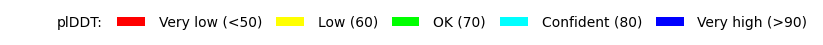

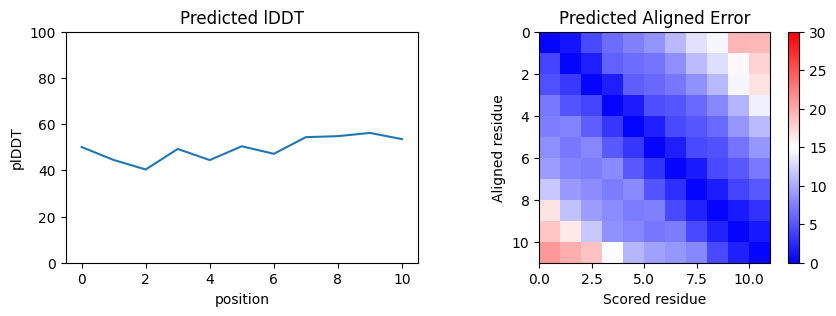

In [2]:
# Cell 3: Predict Structure for a Sequence

# @title Change the sequence of aminoacids to a different one (e.g. all Alanines, all Leucines, etc.).
# What is the difference in the predicted structure?
sequence = "GGGGGGGGGGG"  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "confidence"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence=sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)


  0%|          | 0/49 [elapsed: 00:00 remaining: ?]

plotting prediction at recycle=48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

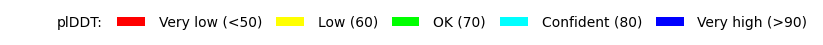

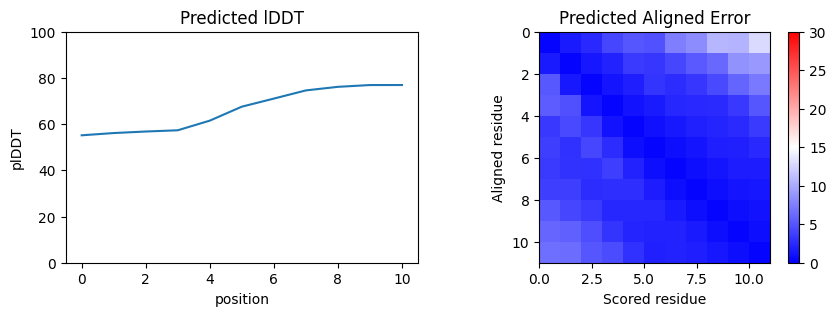

In [3]:
# Cell 3.1: Predict Structure for a Sequence

# All Alanins
sequence = "AAAAAAAAAAA"  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "confidence"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence=sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)

  0%|          | 0/49 [elapsed: 00:00 remaining: ?]

plotting prediction at recycle=48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

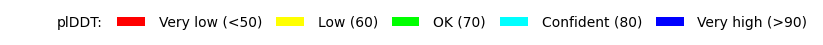

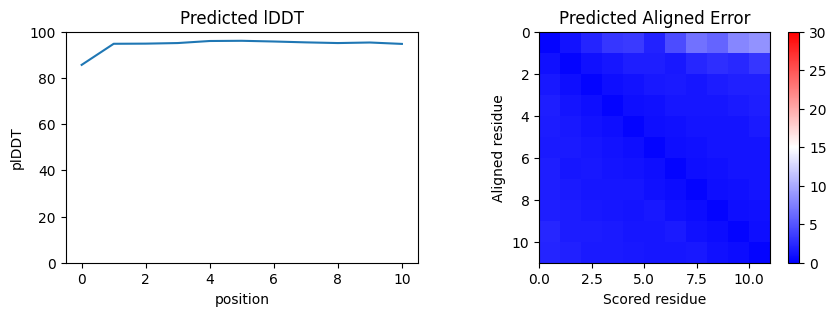

In [4]:
# Cell 3.1: Predict Structure for a Sequence

# All Leucines
sequence = "LLLLLLLLLLL"  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "confidence"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence=sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)

  0%|          | 0/49 [elapsed: 00:00 remaining: ?]

plotting prediction at recycle=48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

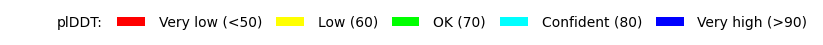

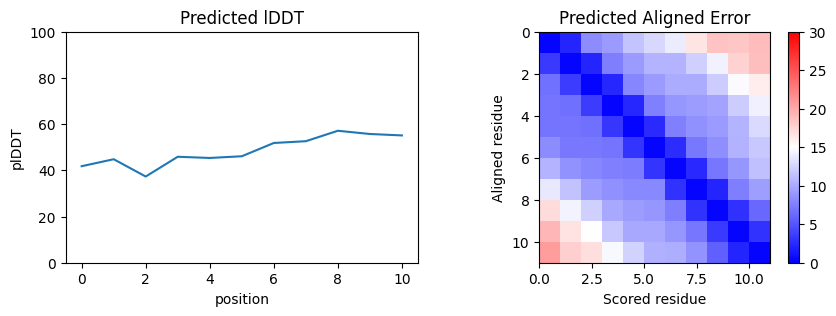

In [5]:
# Cell 3.1: Predict Structure for a Sequence

# All Serine
sequence = "SSSSSSSSSSS"  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "confidence"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence=sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)

  0%|          | 0/49 [elapsed: 00:00 remaining: ?]

plotting prediction at recycle=48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

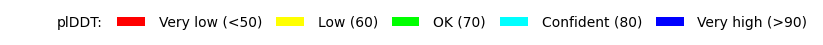

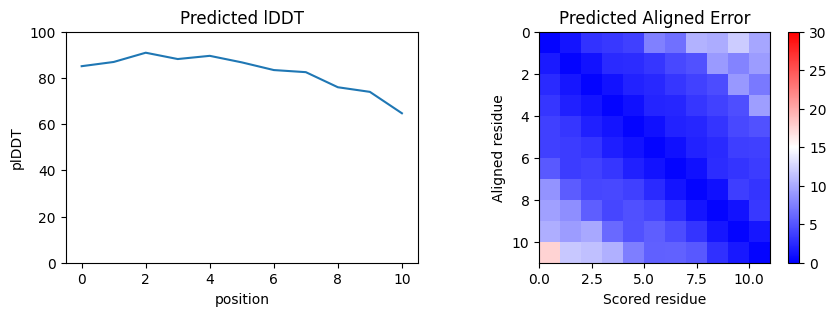

In [6]:
# Cell 3.1: Predict Structure for a Sequence

# All Lysins
sequence = "KKKKKKKKKKK"  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "confidence"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence=sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)

🔧 Compiling AlphaFold model (this may take a moment)...
✅ Model compiled successfully!


  0%|          | 0/49 [elapsed: 00:00 remaining: ?]

plotting prediction at recycle=48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

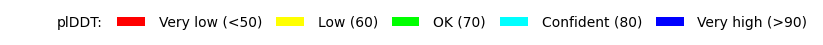

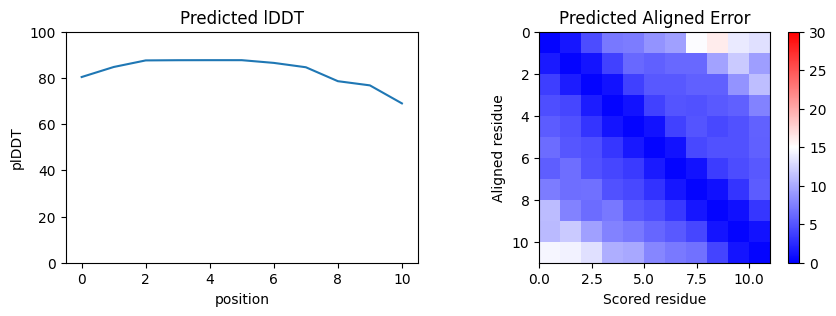

In [3]:
# Cell 3.1: Predict Structure for a Sequence

# All Prolines
sequence = "PPPPPPPPPPP"  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "confidence"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence=sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)

  0%|          | 0/49 [elapsed: 00:00 remaining: ?]

plotting prediction at recycle=48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

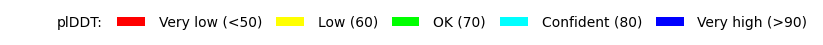

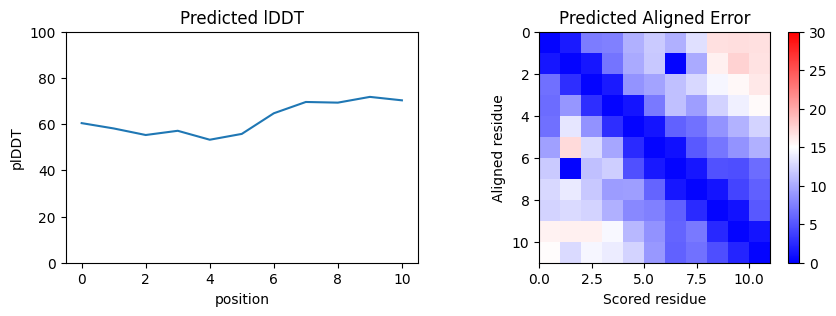

In [6]:
# Cell 3.1: Predict Structure for a Sequence

# All Arginines
sequence = "RRRRRRRRRRR"  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "confidence"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence=sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)

# What is the difference in the predicted structure?

The peptides composed of Alanine, Leucine, and Lysine form well-defined, highly stable alpha-helical structures. This stability is high (pLDDT ~ 85-95) due to the non-polar (Ala, Leu) or charged (Lys) side chains favoring the helical backbone conformation.

The structure for Proline is distinct, forming an ordered but different structure, after a literature search, we found that the structure is called Polyproline II (PPII) helix.

In contrast to all the ordered structures, the peptides made of Glycine and Serine do not form stable, ordered secondary structures. They appear as more extended, flexible, or random coil-like structures. Their prediction confidence is low (pLDDT < 60), suggesting AlphaFold is uncertain about a single, fixed structure due to the high inherent flexibility of Glycine or the small polar side chain of Serine.

The Arginine structure is moderately confident (pLDDT ~ 60-70) and appears as a partially ordered coil/turn structure. The high density of large, positive charges in this short peptide likely causes repulsion that inhibits the close packing required to form a stable alpha-helix, leading to a more extended, less defined structure than Leucine or Lysine.






  0%|          | 0/49 [elapsed: 00:00 remaining: ?]

plotting prediction at recycle=48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

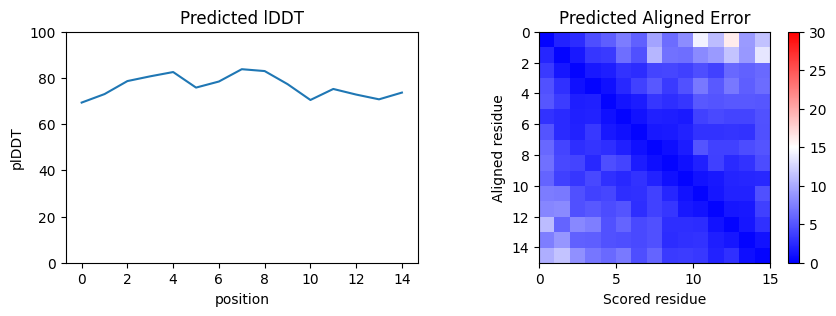

In [7]:
# Cell 3: Predict Structure for a Sequence

# @title Design sequences that fold into a ALPHA HELIX secondary structures (see figure above)
sequence = "RKALAKALEAKALAR"  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "rainbow"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)


# alpha-helix

First, we simply tried to put Alanine with Leucines together (AAAAALLLLL), this did not work, likey because it lacks the stabilisation with salt bridges. Furthermore, the Leucines placed at the C-terminal end create a hydrophobic block may prevent the alpha-helix formation. In summary, the sequence lacks stabilizer.

This is the reason, why we tried the next sequence shown above. The sequence is built mainly from Alanine and Leucince which showed in the previous section a alpha-helix structure. Alanine has a small side chain which minimizes steric hindrance and allows the formation of the alpha helix. Leucine is hydrophopbic and can pack tightly with other residues, leading to a stable and compact helical core.
Importantly there are oppositely charged amino acids in the structure (Lysine and Arginine --> positive, Glutamate --> negative), that form stabilizing salt bridges, which staples the helix together. An alpha-helix completes one turn every 3.6 residues. This means that residues seperated by three or four positions end up positioned on the same face of the helix, close enough for their side chains to interact. Lysine and Glutamate are seperated by four residues in the central part of the sequence --> can form salt bridges.

Arginine is a highly positive residue and is placed at the ends of the sequence. Ithelps neutralize the charge of the helix dipole.

In [ ]:
# Cell 3: Predict Structure for a Sequence

# @title Design sequences that fold into TWO HELICES (see figure above)
sequence = ""  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "rainbow"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)


  0%|          | 0/49 [elapsed: 00:00 remaining: ?]

plotting prediction at recycle=48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

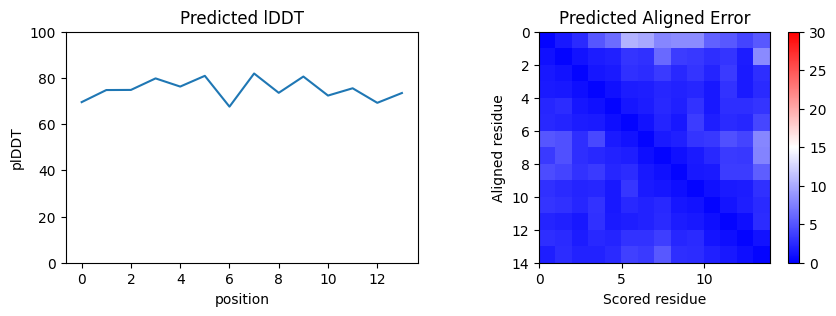

In [9]:
# Cell 3: Predict Structure for a Sequence

# @title Design sequences that fold into BETA SHEETS (see figure above)
sequence = "FCFCFCFCFCFCFC"  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "rainbow"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)


# Beta-Sheet formation

The peptide chain folds back on itself to form a compact structure composed of two major parallel or anti-parallel segments (strands) that are flat and extended. The two strands are held together by backbone-backbone hydrogen bonds between C=O groups of one strand and N=H groups of the other strand.

Cysteine has a thiol side-chain, when two Cysteine residues met their thiol groups can form disulfide bonds. We have 7 Cyteins in the sequence which can form mutliple covalent bonds that act as structural cross-links, forcing the peptide to a folded shape.

Phenylalanine has a large hydrophobic side chain with a non-polar aromatic ring. These residues cluster together on the interior of the folded structure, stabilizing hydrophobic interactions and van der Waals forces.

In [ ]:
# Cell 3: Predict Structure for a Sequence

# @title Design a sequence that fold into 4 helix bundle (take a look at e.g. 3VJF)
sequence = ""  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "rainbow"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)


---

# Project Assignment: Protein Disruption Analysis  

## Background

Now apply what you learned to YOUR project protein. The goal is to:
1. Predict your protein's structure
2. **Rationally design** mutations that disrupt it
3. **Test hypotheses** about which regions are critical

## Part 1: Baseline Prediction  

### Task P.1: AlphaFold Prediction vs Crystal Structure

**First, check [AlphaFold Database](https://alphafold.ebi.ac.uk/)** - your protein might already be there!

If not, use:
- [AlphaFold Server](https://alphafoldserver.com/welcome),
- [AlphaFold Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb),
- OR [ColabFold](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb) (faster)

**Required analysis:**

**Questions to answer:**
1. **What is the mean pLDDT score?**
   - Overall:
   - Interpretation:

2. **Which regions have highest confidence (pLDDT > 90)?**
   - Residues:
   - Why? (secondary structure, core vs surface):

3. **Which regions have lowest confidence (pLDDT < 70)?**
   - Residues:
   - Why? (loops, disordered, termini):

4. **RMSD with crystal structure:**
   - Overall RMSD:
   - Command used (e.g., PyMOL `rms_cur`):
   - Regions of high deviation:
   - Why these regions differ:

5. **PAE (Predicted Aligned Error) analysis:**
   - Well-resolved domains:
   - Uncertain inter-domain contacts:
   - What this tells you about protein architecture:

## Part 2: Rational Mutation Design  

### Task P.2: Hypothesis-Driven Disruption

**BEFORE testing mutations**, complete this analysis:

#### Strategy 1: Core Disruption
**Target:** Hydrophobic core residues

**Identify core residues:**
- Which residues form the hydrophobic core? (use structure viewer)
- List at least 3 candidates:

**Design mutations:**
- Mutation 1: [original]→[mutant] at position [X]
  - Why this will disrupt:
  - Prediction: pLDDT will drop to ~[value]

- Mutation 2:
  - Reasoning:

- Mutation 3:
  - Reasoning:

#### Strategy 2: Helix/Sheet Disruption  
**Target:** Critical secondary structure elements

**Identify critical secondary structures:**
- Which helix/sheet is most important? Why?
- Residues:

**Design mutations:**
- Proline insertion at position [X] because...
- Expected effect:

#### Strategy 3: Salt Bridge Disruption
**Target:** Electrostatic interactions

**Identify salt bridges:**
- [Residue A] with [Residue B]
- Distance:
- Importance:

**Design mutations:**
- Mutation:
- Why disruptive:

#### Strategy 4: Disulfide Bond Disruption (if applicable)
**If your protein has disulfide bonds:**
- Which cysteines form bonds?
- Mutation strategy:

## Part 3: Testing and Analysis  

### Task P.3: Predict Mutants

Test your designed mutations. For EACH mutation:

**Mutation [name]:**
- Hypothesis:
- Predicted pLDDT:
- Actual pLDDT:
- Structure changes observed:
- Did hypothesis hold?:
- Explanation:

### Summary Analysis

**Most disruptive mutation type:**

**Least disruptive:**

**Surprising findings:**

**What this reveals about your protein's stability:**

**Clinical/functional implications:**
- If these mutations occurred naturally:
- Disease relevance:

## Reference: Protein Stabilizing Forces

<img src="https://github.com/yerkoescalona/structural_bioinformatics/blob/w2023/ex02/structure_stabilizing_forces.png?raw=1" width="600"/>

## Bonus: MSA Analysis  

Use [Clustal Omega](https://toolkit.tuebingen.mpg.de/tools/clustalo) or this [MSA notebook](https://colab.research.google.com/github/yerkoescalona/structural_bioinformatics/blob/main/ex02/msa.ipynb)

**Question:** Are the residues you targeted for mutation conserved across species?
- If yes: Strong evidence they're critical
- If no: Why might non-conserved residues still be important in your specific protein?






Happy modeling!